In [22]:
import numpy as np
import h5py, os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader 

In [41]:
def load_and_standardize_data(file, expected_columns=78):
    """
    Load data from a file, filter rows with the expected number of columns, 
    and standardize the features.
    
    Parameters:
    file (str): The path to the data file.
    expected_columns (int): The expected number of columns in the dataset.
    
    Returns:
    numpy array: The standardized features.
    """
    data = []
    with open(file, 'r') as f:
        for line in f:
            split_line = line.strip().split(',')
            if len(split_line) == expected_columns:
                data.append(split_line)
    
    data = np.array(data, dtype=float)
    
    # Standardize the features
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    standardized_data = (data - mean) / std
    
    return standardized_data

# Usage Example
data_file = '/Users/amanda/Desktop/PhD/Papers/sn_vae_anomaly/features_batch.csv'
standardized_features = load_and_standardize_data(data_file)

In [42]:
df = pd.DataFrame(standardized_features, columns=[f'Feature_{i+1}' for i in range(78)])

In [43]:
df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,Feature_74,Feature_75,Feature_76,Feature_77,Feature_78
count,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,...,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05,3.459970e+05
mean,-2.264721e-16,7.005684e-16,-8.755359e-16,-1.541478e-15,-5.278803e-17,-9.353158e-14,9.418880e-17,-4.066147e-17,2.251783e-17,2.860485e-14,...,3.170880e-13,-3.148183e-17,-7.435771e-13,-3.810678e-16,1.645260e-15,9.506569e-16,1.469730e-13,-1.314310e-17,2.292952e-14,5.033253e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.481811e+01,-1.702124e-02,-1.811617e+01,-3.394903e+02,-2.753834e+02,-5.866262e+00,-5.030426e-02,-1.117404e-01,-1.241001e-01,-3.386536e+02,...,-8.625389e+00,-2.443919e+02,-5.619415e+00,-2.067825e-01,-2.423196e-01,-2.006926e-01,-2.785181e+00,-1.890762e+02,-5.854747e-01,-1.562245e-01
25%,2.984565e-03,-1.652560e-02,-1.527954e-01,-8.776056e-03,2.183913e-03,-7.119440e-01,-1.733319e-02,-1.460559e-02,-1.593654e-02,-4.966581e-02,...,-3.838202e-01,7.999216e-03,-8.660531e-01,-1.810506e-01,-1.800962e-01,-1.550698e-01,-6.558986e-01,-3.254236e-02,-3.071905e-01,-1.541995e-01
50%,9.789848e-03,-1.637895e-02,-1.473393e-01,6.657222e-03,3.071599e-03,-1.195058e-01,-1.717741e-02,-1.443737e-02,-1.574189e-02,2.459179e-03,...,1.441687e-01,2.380091e-02,-5.350189e-01,-1.735021e-01,-1.660412e-01,-1.434179e-01,1.105565e-02,2.288332e-03,-1.851792e-01,-1.535249e-01
75%,2.149133e-02,-1.606514e-02,-1.385935e-01,1.978645e-02,4.024856e-03,1.074879e+00,-1.677090e-02,-1.415800e-02,-1.543018e-02,5.719042e-02,...,5.896848e-01,4.256616e-02,1.179452e+00,-1.561438e-01,-1.453626e-01,-1.242247e-01,7.006425e-01,3.699251e-02,2.806002e-02,-1.522011e-01
max,3.808606e-01,2.187259e+02,1.340815e+02,6.918692e-02,1.592816e+02,1.491341e+00,2.082360e+02,2.462333e+02,1.959199e+02,1.418935e-01,...,3.163535e+00,6.795319e+01,1.469087e+00,1.498169e+02,1.183084e+02,2.559342e+02,2.093640e+00,2.159199e+02,8.058381e+01,7.474230e+01


In [27]:
class Encoder(nn.Module):
    '''
    encoder produces mean and log of variance 
    (i.e., parateters of simple tractable normal distribution "q"
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim[0])
        self.FC_hidden = nn.ModuleList([nn.Linear(hidden_dim[i], hidden_dim[i+1]) for i in range(len(hidden_dim)-1)])
        #self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim[-1], latent_dim)
        self.FC_var   = nn.Linear (hidden_dim[-1], latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_input(x))
        for i, FC in enumerate(self.FC_hidden):
            h = self.LeakyReLU(FC(h))
        mean = self.FC_mean(h)
        log_var = self.FC_var(h)
        return mean, log_var
        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_latent = nn.Linear(latent_dim, hidden_dim[0])
        self.FC_hidden = nn.ModuleList([nn.Linear(hidden_dim[i], hidden_dim[i+1]) for i in range(len(hidden_dim)-1)])
        self.FC_output = nn.Linear(hidden_dim[-1], output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_latent(x))
        for i, FC in enumerate(self.FC_hidden):
            h = self.LeakyReLU(FC(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_encoder, hidden_dim_decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim_encoder, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim_decoder, output_dim=input_dim)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)  # sampling epsilon        
        z = mean + var*epsilon       # reparameterization trick
        return z
        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

def AllLoss(x, x_hat, mean, log_var, lambda_kld):
    Reco = RecoLoss(x_hat, x)
    KLD  = KLDLoss(mean, log_var)
    return Reco + lambda_kld*KLD, Reco, lambda_kld*KLD

def RecoLoss(x_hat, x, reduction='sum'):
    return nn.functional.binary_cross_entropy(x_hat, x, reduction=reduction)
    
def KLDLoss(mean, log_var, reduction='sum'):
    if reduction=='sum':
        return - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    elif reduction=='none':
        return - 0.5 * (1+ log_var - mean.pow(2) - log_var.exp())

In [28]:
N_train = 1000000
N_test = 1000000
N_val = 1000000

dataset = torch.utils.data.TensorDataset(torch.tensor(standardized_features, dtype=torch.float32))
train_dataset = dataset[:N_train, :]
val_dataset  = dataset[N_train:N_train+N_val, :]
test_dataset  = dataset[N_train+N_val:N_train+N_val+N_test, :]

# Visualise Training Data

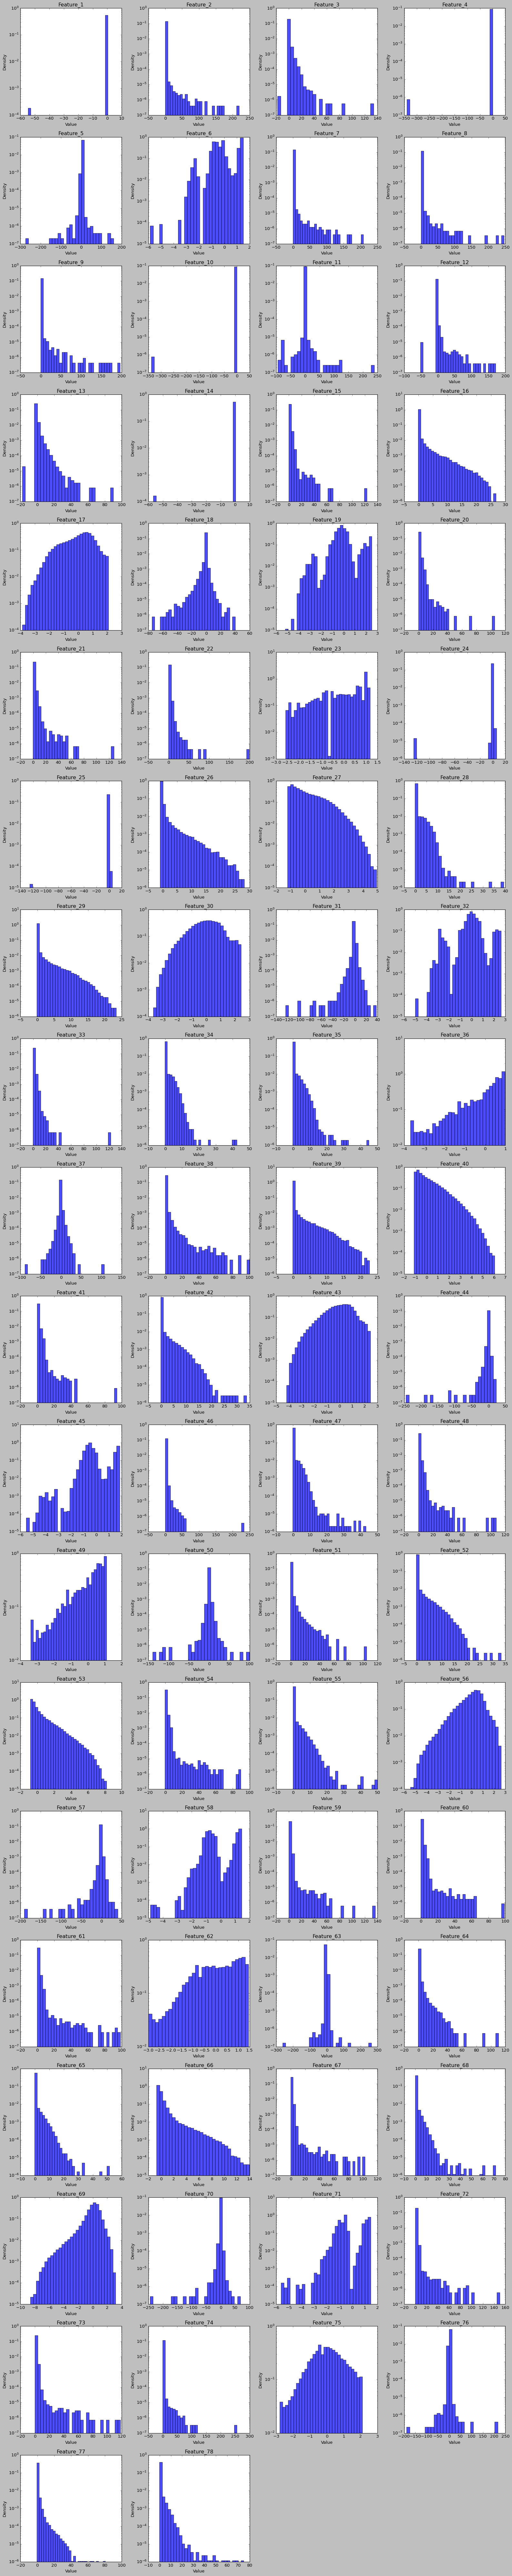

In [45]:
# Plot histograms for each column of the DataFrame
def plot_histograms(dataframe):
    num_columns = dataframe.shape[1]
    num_rows = int(np.ceil(num_columns / 4))  # 4 histograms per row
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    for i, column in enumerate(dataframe.columns):
        row, col = divmod(i, 4)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.hist(dataframe[column], bins=30, density=True, color='blue', alpha=0.7)
        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.set_yscale('log')
    
    # Remove empty subplots
    for j in range(i + 1, num_rows * 4):
        row, col = divmod(j, 4)
        fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])
    
    plt.tight_layout()
    plt.show()

# Plot histograms
plot_histograms(df)